# Clustering algorithms in word embedding models

## word2vec

In [1]:
from gensim.models import Word2Vec

# load pre-trained model
model = Word2Vec.load("../word2vec/models/rus/sentirueval_old/300features_20minwords_10context_full")
# For binary models
# model = Word2Vec.load_word2vec_format('../models/***.bin', binary=True)

print("Model: %s" % model)

# Word vectors
word_vectors = model.syn0
# List of words
words = model.index2word

print('# words in model: %s' % len(word_vectors))
print()

num_2_show = 10
print("First %d words:" % num_2_show)
for ix, word in enumerate(words[:num_2_show]):
    print(word)

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Model: Word2Vec(vocab=1619, size=300, alpha=0.025)
# words in model: 1619

First 10 words:
нормальный
хабаровский
система
48
результат
свалка
рассказывать
екатеринбург
устраивать
баланс


## Compute Cosine Similarity

Use Cosine Similarity measure to calculate the similarity between different documents. Source: http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [2]:
import scipy

def cos_cdist(matrix, vector):
    """
    Compute the cosine distances between each row of matrix and vector.
    """
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

## Apply fuzzy c-means clustering (FCM) for word vectors

### Set number of clusters

In [3]:
n_clusters = 30

### Clustering

In [4]:
%matplotlib inline

import sys
from time import time
import numpy as np
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import skfuzzy


X = word_vectors

print("Shape of input array: ", X.shape)
print()

print("Clustering algorithm:")
print("Fuzzy c-means")

t0 = time()
fcm_centers, u, u0, d, jm, p, fpc = skfuzzy.cluster.cmeans(X.transpose(), 
                                                           n_clusters, 
                                                           2, 
                                                           error=1e-4, 
                                                           maxiter=1000, 
                                                           init=None)
print("Execution time: %0.3fs" % (time() - t0))

Shape of input array:  (1619, 300)

Clustering algorithm:
Fuzzy c-means
Execution time: 8.306s


### Visualization

Using Principal Component Analysis (PCA) (https://en.wikipedia.org/wiki/Principal_component_analysis) and compute Fuzzy Partial Coefficient (FPC) ().

Fuzzy Partition Coefficient: 0.039



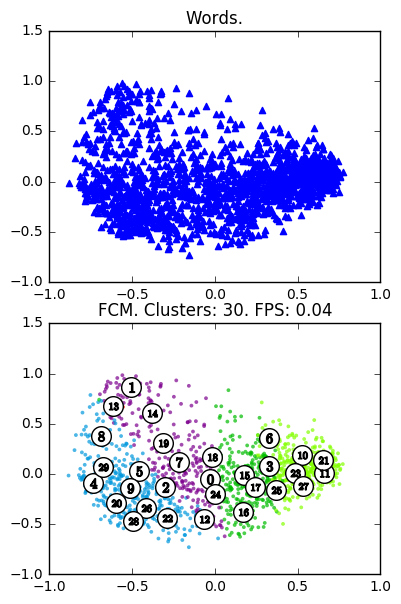

In [5]:
pca = PCA(2)
pca_vectors = pca.fit_transform(word_vectors)

# tsne = TSNE(n_components=2, random_state=0)
# pca_vectors = tsne.fit_transform(word_vectors)

fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 6))
fig.tight_layout()

ax1.scatter(pca_vectors[:, 0],
            pca_vectors[:, 1],
            marker='^',
            color='b')

# For showing on the plot
fcm_pca_centers, pca_u, _, _, _, _, _ = skfuzzy.cluster.cmeans(pca_vectors.transpose(), 
                                                               n_clusters, 
                                                               2, 
                                                               error=1e-4, 
                                                               maxiter=1000, 
                                                               init=None)

# Fuzzy labels
fcm_labels = np.argmax(u, axis=0)

colors = cm.spectral(fcm_labels.astype(float) / n_clusters)
ax2.scatter(pca_vectors[:, 0], 
            pca_vectors[:, 1],
            marker='.', s=30, lw=0, alpha=0.7, c=colors)

centers = fcm_pca_centers
ax2.scatter(centers[:, 0],
            centers[:, 1],
            marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    ax2.scatter(c[0],
                c[1],
                marker='$%d$' % i, alpha=1, s=50)

print("Fuzzy Partition Coefficient: %0.3f" % fpc)
print()

ax1.set_title('Words.')
ax2.set_title('FCM. Clusters: {0}. FPS: {1:.2f}'.format(n_clusters, fpc))

## Calculate semantic word vectors

### Cosine Similarity inside each cluster

In [6]:
words_array = np.asarray(words)

# Words in each cluster
f_cluster_words = []
f_cluster_vectors = []
f_cluster_pca_vectors = []

# Distance for word in each cluster
f_cluster_cos_sim = []
f_cluster_cos_sim_sort_asc = []
f_cluster_cos_sim_sort_des = []

for i in range(n_clusters):
    f_cluster_words.append(words_array[fcm_labels == i])
    f_cluster_vectors.append(word_vectors[fcm_labels == i])
    f_cluster_pca_vectors.append(pca_vectors[fcm_labels == i])
    
    f_cluster_cos_sim.append(cos_cdist(f_cluster_vectors[i], fcm_centers[i]))
    f_cluster_cos_sim_sort_asc.append(f_cluster_cos_sim[i].argsort())
    f_cluster_cos_sim_sort_des.append(f_cluster_cos_sim_sort_asc[i][::-1])

### Semantic vector for each word in model using FCM

Set threshold according to the experiment.

In [7]:
# TODO: find this value
CLUSTER_THRESHOLD = 0.5
INVALID_VALUE = 2.0 # MAX value
UNKNOWN_VECTOR = np.empty(n_clusters)
UNKNOWN_VECTOR.fill(INVALID_VALUE)

In [8]:
num_words = len(word_vectors)

# Shape is (num words in model) * (num clusters)
f_semantic_word_vectors = np.zeros(shape=(num_words,n_clusters))

for ix_cluster, center in enumerate(fcm_centers):
    f_semantic_word_vectors[:, ix_cluster] = cos_cdist(word_vectors, center)
    ix2discard = f_semantic_word_vectors[:, ix_cluster] > CLUSTER_THRESHOLD  # threshold values
    f_semantic_word_vectors[ix2discard, ix_cluster] = INVALID_VALUE

#### Example output (semantic vectors)

In [9]:
print("Semantic word vectors shape: ", f_semantic_word_vectors.shape)
for ix, vector in enumerate(f_semantic_word_vectors[:2,:]):
    print("Word: ", words[ix])
    min_ix = np.argmin(vector) # [np.nonzero(vector)]
    print("Cluster: ", min_ix, " Distance: ", vector[min_ix])
    print("Vector: ", vector.shape)
    print(vector)
    print()

Semantic word vectors shape:  (1619, 30)
Word:  нормальный
Cluster:  19  Distance:  0.105469750698
Vector:  (30,)
[ 2.          0.10547098  2.          2.          0.10548031  2.
  0.10547208  0.10547722  0.10547118  2.          0.10550011  2.          2.
  2.          0.10552223  0.10559981  2.          0.1054764   2.
  0.10546975  0.10547366  2.          0.10547016  0.10548578  0.10548034
  2.          2.          2.          2.          2.        ]

Word:  хабаровский
Cluster:  9  Distance:  0.123668943969
Vector:  (30,)
[ 0.12366984  2.          0.12368488  0.12366946  2.          0.12366929
  2.          2.          2.          0.12366894  2.          0.12367047
  0.12366896  0.12366988  2.          2.          0.12367066  2.
  0.12366919  2.          2.          0.12366959  2.          2.          2.
  0.12367165  0.12366959  0.1236706   0.12367893  0.1236693 ]



### Test semantic model on small text

In [10]:
test_texts = [["мтс", "плохо", "работать", "москва"],
              ["сбер", "договор", "воронеж", "криво"]] # ["мегафон", "баланс", "0"]
test_vectors = np.zeros((len(test_texts), n_clusters))

for ix, test_text in enumerate(test_texts):
    num_test_words = 0
    print("Text: ", test_text)
    
    for word in test_text:
        index = np.where(words_array == word)
        if index[0] != 0:
            vector = f_semantic_word_vectors[index]
            num_test_words += 1
        else:
            continue
#             vector = UNKNOWN_VECTOR
        test_vectors[ix] += vector[0]
        print("Word: ", word, 
              " Cluster: ", np.argmin(vector),
              " Distance: ", vector[0, np.argmin(vector)])
#         print(index)
#         print(vector)
        print()

    if num_test_words != 0:
        test_vectors[ix] = np.divide(test_vectors[ix], num_test_words)

    min_ix = np.argmin(test_vectors[ix])
    print("Cluster: ", min_ix, " Distance: ", test_vectors[ix, min_ix])
    print("Vector: ", test_vectors[ix].shape)
    print(test_vectors[ix])
    print()

print("Cosine similarity: ", scipy.spatial.distance.cosine(test_vectors[0], test_vectors[1]))

Text:  ['мтс', 'плохо', 'работать', 'москва']
Word:  мтс  Cluster:  19  Distance:  0.283326867251

Word:  плохо  Cluster:  19  Distance:  0.102062893878

Word:  работать  Cluster:  19  Distance:  0.27957448026

Word:  москва  Cluster:  15  Distance:  0.478243382882

Cluster:  19  Distance:  0.2858366991
Vector:  (30,)
[ 1.62228748  0.28583758  1.62228552  1.62228753  0.28584424  1.62228755
  0.28583836  0.28584204  0.28583772  1.6222876   0.28585838  1.6222874
  1.62228759  1.62228748  0.28587418  0.28592957  1.62228738  0.28584145
  1.62228756  0.2858367   0.28583949  1.62228751  0.28583699  0.28584814
  0.28584426  1.62228725  1.62228751  1.62228738  1.6222863   1.62228755]

Text:  ['сбер', 'договор', 'воронеж', 'криво']
Word:  сбер  Cluster:  0  Distance:  2.0

Word:  договор  Cluster:  15  Distance:  0.498761503526

Word:  воронеж  Cluster:  2  Distance:  0.337684578688

Cluster:  2  Distance:  1.44589485956
Vector:  (30,)
[ 1.44589828  1.49958959  1.44589486  1.44589837  1.4995894

## Additional visualization

### Words distribution around the clusters

[  0   0 321   0   0   0   0   0   0 484   0   0   0   0   0 315   1   0
   0 497   0   0   0   0   0   0   1   0   0   0]


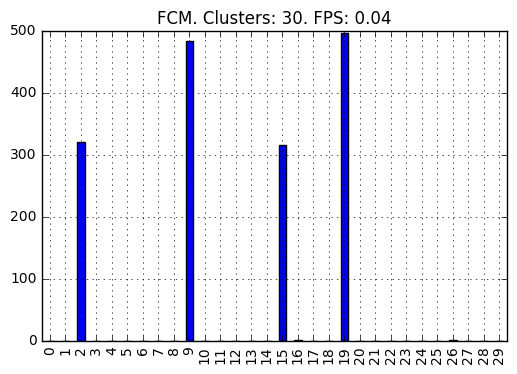

In [11]:
import pandas


cluster_words_num = np.asarray([len(a) for a in f_cluster_words])
print(cluster_words_num)

df = pandas.DataFrame(data=cluster_words_num,
                      index=range(n_clusters))
df.plot(kind='bar',
        title='FCM. Clusters: {0}. FPS: {1:.2f}'.format(n_clusters, fpc),
        grid=True,
        legend=False)

### Words in clusters

In [12]:
n_top_terms = 5
print("Top %d terms per fuzzy cluster:" % n_top_terms)

Top 5 terms per fuzzy cluster:


#### Using Cosine Similarity

In [13]:
for i in range(n_clusters):
    print("Cluster %d: %d" % (i, f_cluster_words[i].shape[0]))
    print("Near")
    for ix in f_cluster_cos_sim_sort_asc[i][:n_top_terms]:
        print(f_cluster_cos_sim[i][ix], f_cluster_words[i][ix])
        
    print()
    print("Far")
    for ix in f_cluster_cos_sim_sort_des[i][:n_top_terms]:
        print(f_cluster_cos_sim[i][ix], f_cluster_words[i][ix])

    print()

Cluster 0: 0
Near

Far

Cluster 1: 0
Near

Far

Cluster 2: 321
Near
0.0505677738209 100%
0.0566087424679 санкт-петербург
0.0692422756286 подарить
0.0721242150771 #читаювзаимно
0.0735977222636 олимпийский

Far
0.869577564291 онлайн
0.852483295449 оформлять
0.842907224961 кредитный
0.833071382033 экспресс
0.825750784764 автокредит

Cluster 3: 0
Near

Far

Cluster 4: 0
Near

Far

Cluster 5: 0
Near

Far

Cluster 6: 0
Near

Far

Cluster 7: 0
Near

Far

Cluster 8: 0
Near

Far

Cluster 9: 484
Near
0.0383008194093 анализ
0.0419968889977 открытый
0.0439651741515 открытие
0.0453190616059 беларусь
0.0504015619685 п

Far
0.789668908479 досрочный
0.768204061288 ипотека
0.741616888493 втб
0.737900105757 физический
0.712666372609 ставка

Cluster 10: 0
Near

Far

Cluster 11: 0
Near

Far

Cluster 12: 0
Near

Far

Cluster 13: 0
Near

Far

Cluster 14: 0
Near

Far

Cluster 15: 315
Near
0.0338209639812 смысл
0.0374073792394 соединение
0.0464636091247 короче
0.0497697546328 успевать
0.050855380099 сменить



#### Using word2vec similarity

In [14]:
for i in range(n_clusters):
    print("Cluster %d: %d" % (i, f_cluster_words[i].shape[0]))
    print("Similar")
    for word in model.similar_by_vector(fcm_centers[i], topn=n_top_terms):
        print(word[1], word[0])    
    print()

Cluster 0: 0
Similar
0.9616991281509399 анализ
0.9580027461051941 открытый
0.9560346007347107 открытие
0.9546806216239929 беларусь
0.9495977163314819 п

Cluster 1: 0
Similar
0.9706092476844788 ;)
0.9698604345321655 доставать
0.9661614894866943 нормально
0.9661241769790649 смысл
0.9632724523544312 зависеть

Cluster 2: 321
Similar
0.9616981744766235 анализ
0.9579966068267822 открытый
0.9560311436653137 открытие
0.9546754360198975 беларусь
0.9495840072631836 п

Cluster 3: 0
Similar
0.9616991877555847 анализ
0.9580028653144836 открытый
0.9560346603393555 открытие
0.9546808004379272 беларусь
0.9495980143547058 п

Cluster 4: 0
Similar
0.9706084728240967 ;)
0.969862699508667 доставать
0.9661588668823242 нормально
0.9661280512809753 смысл
0.9632678031921387 зависеть

Cluster 5: 0
Similar
0.9616991877555847 анализ
0.9580029249191284 открытый
0.956034779548645 открытие
0.9546809196472168 беларусь
0.9495981335639954 п

Cluster 6: 0
Similar
0.9706091284751892 ;)
0.9698606729507446 доставать
0.9661

### Words disposition

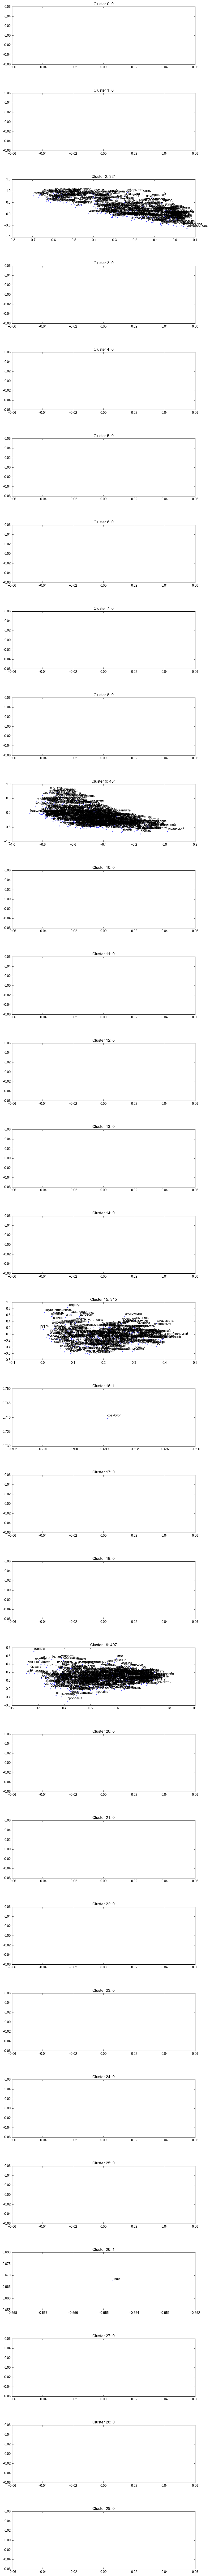

In [15]:
from matplotlib import rc

rc('font', family='Arial')

# centers = pca.fit_transform(km.cluster_centers_)
# centers = km_pca.cluster_centers_

fig, axs = plt.subplots(n_clusters,1, figsize=(10, 140), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_clusters):
    x = f_cluster_pca_vectors[i][:, 0]
    y = f_cluster_pca_vectors[i][:, 1]
    
    axs[i].set_title("Cluster %d: %d" % (i, f_cluster_words[i].shape[0]))
    axs[i].scatter(x, 
                   y,
                   marker='.', s=30, lw=0, alpha=0.7)

    cluster_words_list = f_cluster_words[i].tolist()

    for ix, label in enumerate(cluster_words_list):
        axs[i].annotate(label,
                        (x[ix], y[ix]),
                        xytext=(0, 3),
                        textcoords = 'offset points', 
                        ha = 'left', 
                        va = 'bottom')
        
#     axs[i].scatter(centers[i, 0],
#                    centers[i, 1],
#                    marker='o', c="white", alpha=1, s=200)

#     axs[i].scatter(centers[i, 0],
#                    centers[i, 1],
#                    marker='$%d$' % i, alpha=1, s=50)